LSTM 기반의 삼성전자 주가 예측 예제
 - yahoo finance 에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이평선 추가

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [2]:
# !pip install yfinance

In [3]:
import yfinance as yf

# 삼성전자의 주식 심볼 설정
symbol = '005930.KS'  # 005930.KS는 삼성전자의 심볼입니다. '.KS'는 한국 주식을 의미합니다.

# 데이터를 가져올 기간 설정
start_date = '2000-01-01'
end_date = '2023-05-25'

# Yahoo Finance에서 데이터를 가져옵니다.
data = yf.download(symbol, start=start_date, end=end_date)

# 데이터 출력
print(data)

[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2000-01-04   6000.0   6110.0   5660.0   6110.0   4537.110352  74195000
2000-01-05   5800.0   6060.0   5520.0   5580.0   4143.548340  74680000
2000-01-06   5750.0   5780.0   5580.0   5620.0   4173.250000  54390000
2000-01-07   5560.0   5670.0   5360.0   5540.0   4113.844238  40305000
2000-01-10   5600.0   5770.0   5580.0   5770.0   4284.635254  46880000
...             ...      ...      ...      ...           ...       ...
2023-05-18  66000.0  66200.0  65700.0  66200.0  66200.000000  14431704
2023-05-19  67800.0  68400.0  67500.0  68400.0  68400.000000  20349345
2023-05-22  68400.0  69000.0  68000.0  68500.0  68500.000000  14470308
2023-05-23  68500.0  68700.0  68100.0  68400.0  68400.000000   8561643
2023-05-24  68100.0  68700.0  68000.0  68500.0  68500.000000   8192896

[5870 r

In [4]:
# 종가(Close) 컬럼을 기반으로 3일 이동평균과 5일 이동평균 계산
data['3MA'] = data['Close'].rolling(window=3).mean()
data['5MA'] = data['Close'].rolling(window=5).mean()

In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
Date,,,,,,,,
2023-05-18,66000.0,66200.0,65700.0,66200.0,66200.0,14431704,65533.333333,65040.0
2023-05-19,67800.0,68400.0,67500.0,68400.0,68400.0,20349345,66533.333333,65900.0
2023-05-22,68400.0,69000.0,68000.0,68500.0,68500.0,14470308,67700.000000,66700.0
2023-05-23,68500.0,68700.0,68100.0,68400.0,68400.0,8561643,68433.333333,67300.0
2023-05-24,68100.0,68700.0,68000.0,68500.0,68500.0,8192896,68466.666667,68000.0


In [6]:
# raw_df = pd.read_csv('./005930.KS_3MA_5MA.csv')  # yahoo finance 로부터 데이터 다운로드
raw_df = data
raw_df.head()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
Date,,,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4537.110352,74195000,NaN,NaN
2000-01-05,5800.0,6060.0,5520.0,5580.0,4143.548340,74680000,NaN,NaN
2000-01-06,5750.0,5780.0,5580.0,5620.0,4173.250000,54390000,5770.000000,NaN
2000-01-07,5560.0,5670.0,5360.0,5540.0,4113.844238,40305000,5580.000000,NaN
2000-01-10,5600.0,5770.0,5580.0,5770.0,4284.635254,46880000,5643.333333,5724.0


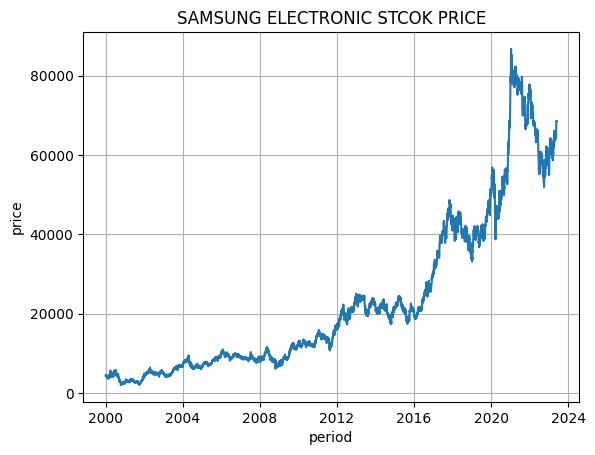

In [7]:
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Adj Close'], label='Adj Close')

plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [8]:
# 통계정보 확인

raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5870.000000,5870.000000,5870.000000,5870.000000,5870.000000,5.870000e+03,5868.000000,5866.000000
mean,26408.032368,26669.107325,26139.286201,26401.407155,22842.832118,2.138491e+07,26397.726653,26394.092738
std,20978.281569,21146.110427,20798.699424,20961.517748,20417.451217,1.527884e+07,20953.035301,20945.157188
min,2540.000000,2760.000000,2420.000000,2730.000000,2027.218994,0.000000e+00,2790.000000,2810.000000
25%,10400.000000,10560.000000,10280.000000,10425.000000,7835.227783,1.169654e+07,10433.333333,10449.000000
50%,18020.000000,18280.000000,17790.000000,18020.000000,14157.299316,1.731500e+07,18036.666667,18018.000000
75%,41795.000000,42100.000000,41515.000000,41847.500000,35839.740234,2.655706e+07,41881.666667,41855.000000
max,90300.000000,96800.000000,89500.000000,91000.000000,86717.320312,1.642150e+08,90433.333333,89960.000000


In [9]:
# Missing Data 확인

raw_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          2
5MA          4
dtype: int64

In [10]:
# 최소값이 0 인 column 체크

for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>


In [11]:
raw_df.loc[raw_df['Volume']==0]

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
Date,,,,,,,,
2000-02-04,5130.0,5130.0,5130.0,5130.0,3809.390625,0,5170.000000,5282.0
2000-03-01,5120.0,5120.0,5120.0,5120.0,3801.966064,0,5013.333333,5046.0
2000-04-05,6800.0,6800.0,6800.0,6800.0,5049.484375,0,6900.000000,6890.0
2000-04-13,6910.0,6910.0,6910.0,6910.0,5131.168457,0,6973.333333,7084.0
2000-05-01,6000.0,6000.0,6000.0,6000.0,4455.428223,0,5800.000000,5728.0
...,...,...,...,...,...,...,...,...
2022-02-28,71900.0,71900.0,71900.0,71900.0,69767.617188,0,71766.666667,72780.0
2022-03-04,72900.0,72900.0,72900.0,72900.0,70737.953125,0,72500.000000,72260.0
2022-03-10,69500.0,69500.0,69500.0,69500.0,67438.796875,0,69700.000000,70980.0


In [12]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 127
3MA: 0
5MA: 0


In [13]:
# 먼저 0 을 NaN 으로 바꾼후, Missing Data 처리

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0


In [14]:
# missing data 확인

raw_df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume       127
3MA            2
5MA            4
dtype: int64

In [15]:
raw_df.isnull().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume        True
3MA           True
5MA           True
dtype: bool

In [16]:
raw_df.loc[raw_df['Open'].isna()]

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
Date,,,,,,,,


In [17]:
# missing data 처리

raw_df = raw_df.dropna()

raw_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [18]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close',
              '3MA', '5MA', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.032556  0.033215   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.033127  0.032434   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.033811  0.032756   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.033583  0.032962   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.033811  0.033628   
...        ...       ...       ...       ...        ...       ...       ...   
5734  0.723108  0.674607  0.726688  0.719044   0.757737  0.715894  0.713991   
5735  0.743619  0.698001  0.747359  0.743967   0.783714  0.727304  0.723861   
5736  0.750456  0.704381  0.753101  0.745100   0.784894  0.740615  0.733043   
5737  0.751595  0.701191  0.754249  0.743967   0.783714  0.748983  0.739929   
5738  0.747037  0.701191  0.753101  0.745100   0.784894  0.749363  0.747963   

        Volume  
0     0.285359  
1     0.363715  


주가예측을 위해 3MA, 5MA, Adj Close 항목을 feature 선정
 - 정답은 Adj Close 선정
 - 시계열 데이터를 위한 window_size = 40 선정

In [19]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [20]:
# feature_df, label_df 생성

feature_cols = [ '3MA', '5MA', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [21]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5739, 3) (5739, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [22]:
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5699, 40, 3) (5699, 1)


학습데이터, 테스트데이터 생성

In [23]:
# train, test 분리

#split = int(len(X)*0.95)
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5499, 40, 3) (5499, 1)
(200, 40, 3) (200, 1)


모델 구축 및 컴파일

In [24]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [25]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
344/344 [==============================] - 4s 9ms/step - loss: 0.0011 - mae: 0.0128 - val_loss: 9.7779e-04 - val_mae: 0.0262
Epoch 2/100
344/344 [==============================] - 3s 9ms/step - loss: 1.5715e-04 - mae: 0.0078 - val_loss: 4.5900e-04 - val_mae: 0.0168
Epoch 3/100
344/344 [==============================] - 3s 9ms/step - loss: 1.3822e-04 - mae: 0.0074 - val_loss: 7.2004e-04 - val_mae: 0.0223
Epoch 4/100
344/344 [==============================] - 3s 9ms/step - loss: 1.3594e-04 - mae: 0.0073 - val_loss: 9.1335e-04 - val_mae: 0.0264
Epoch 5/100
344/344 [==============================] - 3s 9ms/step - loss: 1.0854e-04 - mae: 0.0067 - val_loss: 5.3952e-04 - val_mae: 0.0191
Epoch 6/100
344/344 [==============================] - 3s 9ms/step - loss: 1.0529e-04 - mae: 0.0066 - val_loss: 3.7106e-04 - val_mae: 0.0152
Epoch 7/100
344/344 [==============================] - 3s 9ms/step - loss: 9.6301e-05 - mae: 0.0062 - val_loss: 2.4246e-04 - val_mae: 0.0120
Epoch 8/100
344/3

예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

7/7 [==============================] - 0s 3ms/step


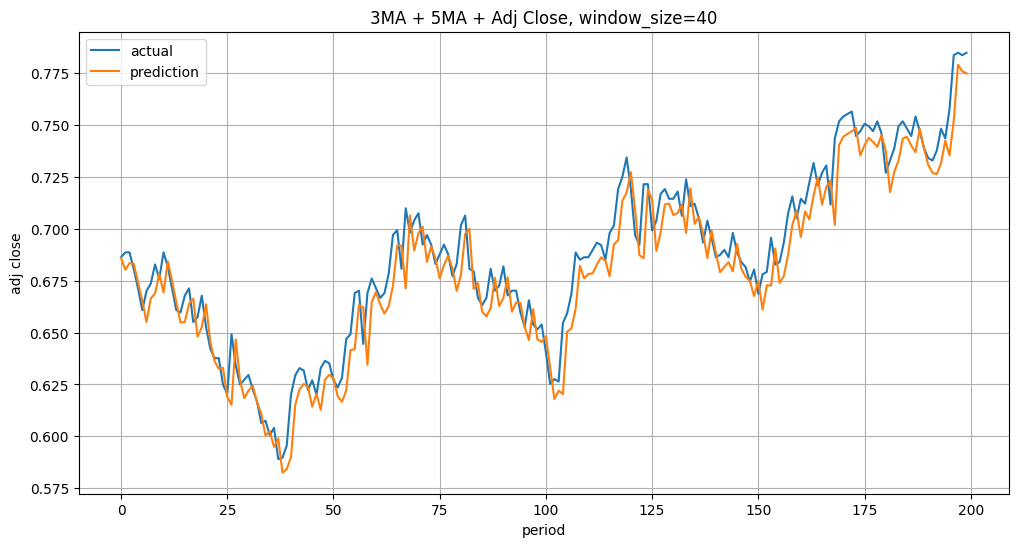

In [27]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [28]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.014917809650364395
